#### Dependencies

In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from math import sqrt
from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

#### Pre-Processing

In [15]:
df = pd.read_csv('../Dataset/Chennai.csv', skiprows = 15)
df.head()

,YEAR,MO,DY,T2M_MAX,T2M,T2M_MIN,TS,RH2M,PS,T2MDEW
0,1981,1,30,28.20,23.86,20.91,24.26,73.88,100.81,18.66
1,1981,1,31,28.94,23.80,20.08,24.21,72.62,100.80,18.28
2,1981,2,1,29.12,23.70,19.56,24.35,77.12,100.81,19.10
3,1981,2,2,28.87,23.86,20.24,24.93,79.69,100.79,19.81
4,1981,2,3,28.81,24.03,20.87,24.80,81.38,100.83,20.34


In [16]:
df['YEAR'] = df.YEAR.astype(str)
df['MO'] = df.MO.astype(str)
df['DY'] = df.DY.astype(str)

df['date'] = df['DY'].str.cat(df['MO'], sep = '/')
df['dateTime'] = df['date'].str.cat(df['YEAR'], sep = '/')

df.drop(['YEAR', 'MO', 'DY','date'], axis=1, inplace=True)

In [17]:
df.set_index('dateTime', inplace = True)
df.index = pd.to_datetime(df.index, dayfirst = True)
df.head()

,T2M_MAX,T2M,T2M_MIN,TS,RH2M,PS,T2MDEW
dateTime,,,,,,,
1981-01-30,28.20,23.86,20.91,24.26,73.88,100.81,18.66
1981-01-31,28.94,23.80,20.08,24.21,72.62,100.80,18.28
1981-02-01,29.12,23.70,19.56,24.35,77.12,100.81,19.10
1981-02-02,28.87,23.86,20.24,24.93,79.69,100.79,19.81
1981-02-03,28.81,24.03,20.87,24.80,81.38,100.83,20.34


In [18]:
df.rename(columns= {'T2M_MAX':'tempMax', 'T2M':'temp', 'T2M_MIN':'tempMin', 'TS':'earthSkin','RH2M':'relativeHumidity','PS':'pressure','T2MDEW':'dew'}, inplace = True)

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
df_transformed = scaler.fit_transform(df)
print(df_transformed)
df.shape

[[0.25638507 0.19338959 0.26992103 ... 0.62801843 0.78828829 0.38764045]
 [0.29273084 0.18917018 0.2103374  ... 0.60479263 0.78378378 0.35714286]
 [0.30157171 0.18213783 0.1730079  ... 0.68774194 0.78828829 0.42295345]
 ...
 [0.51277014 0.52672293 0.57860732 ... 0.56221198 0.5990991  0.67977528]
 [0.37868369 0.43811533 0.58650395 ... 0.69585253 0.54054054 0.72792937]
 [0.39440079 0.43178622 0.5707107  ... 0.78470046 0.54054054 0.80577849]]


(15390, 7)

In [20]:
def split_sequences(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(data):
            break

        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, :]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

In [21]:
train, test = train_test_split(df_transformed, test_size = 0.25, shuffle = False)
n_epochs = 30
n_neurons = 128
n_steps_in = 7
n_steps_out = 1
dropout_rate = 0.3
n_features = train.shape[1]
x_train, y_train, x_test, y_test = [],[],[],[]

for i in range(1, len(train)):
    x_train.append(train[i-1])
    y_train.append(train[i])

for i in range(1, len(test)):
    x_test.append(test[i-1])
    y_test.append(test[i])

X_train, Y_train = split_sequences(train, n_steps_in, n_steps_out)
X_test, Y_test = split_sequences(test, n_steps_in, n_steps_out)

X_train = X_train.reshape((X_train.shape[0], n_steps_in, n_features))
Y_train = Y_train.reshape((Y_train.shape[0], n_steps_out, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps_in, n_features))
Y_test = Y_test.reshape((Y_test.shape[0], n_steps_out, n_features))

#### Architecture

In [22]:
model = Sequential()
model.add(LSTM(n_neurons, activation='tanh', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(Dense(n_neurons, activation='tanh'))
model.add(Dropout(dropout_rate))
model.add(LSTM(n_neurons, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features, activation='linear')))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=n_epochs, verbose=1)

2023-04-22 17:14:46.236452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-22 17:14:46.239108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-22 17:14:46.240253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2023-04-22 17:14:46.493645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-22 17:14:46.496027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-22 17:14:46.497422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

361/361 [==============================] - 8s 11ms/step - loss: 0.0148 - accuracy: 0.5978
Epoch 2/30
361/361 [==============================] - 4s 10ms/step - loss: 0.0050 - accuracy: 0.7173
Epoch 3/30
361/361 [==============================] - 3s 9ms/step - loss: 0.0042 - accuracy: 0.7406
Epoch 4/30
361/361 [==============================] - 4s 10ms/step - loss: 0.0037 - accuracy: 0.7577
Epoch 5/30
361/361 [==============================] - 5s 14ms/step - loss: 0.0036 - accuracy: 0.7567
Epoch 6/30
361/361 [==============================] - 5s 13ms/step - loss: 0.0035 - accuracy: 0.7682
Epoch 7/30
361/361 [==============================] - 5s 13ms/step - loss: 0.0033 - accuracy: 0.7703
Epoch 8/30
361/361 [==============================] - 4s 11ms/step - loss: 0.0032 - accuracy: 0.7728
Epoch 9/30
361/361 [==============================] - 4s 11ms/step - loss: 0.0031 - accuracy: 0.7748
Epoch 10/30
361/361 [==============================] - 5s 13ms/step - loss: 0.0031 - accuracy: 0.7761
E

In [23]:
Y_real = scaler.inverse_transform(Y_test[:,0])
Y_real[:,0]

Y_predict = []
for i in range(len(X_test)):
    X_pred = X_test[i].reshape((1, X_test[i].shape[0], n_features))
    Y_pred = model.predict(X_pred)
    Y_pred_it = scaler.inverse_transform(Y_pred[0])
    Y_predict.append(Y_pred_it)

2023-04-22 17:17:11.276211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-22 17:17:11.279393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-22 17:17:11.281421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 44ms/step


#### Prediction

In [24]:
Temp = []
for elements in Y_predict:
    Temp.append(elements[0][0])

Y_predict = np.array(Y_predict)
Y_real = np.array(Y_real)

rmse = sqrt(mean_squared_error(Y_real[:,0], Temp))
mae = mean_absolute_error(Y_real[:,0], Temp)
mape = mean_absolute_percentage_error(Y_real[:,0], Temp)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 1.1600296856064132
MAE: 0.850528419711136
MAPE: 0.026484438349325002


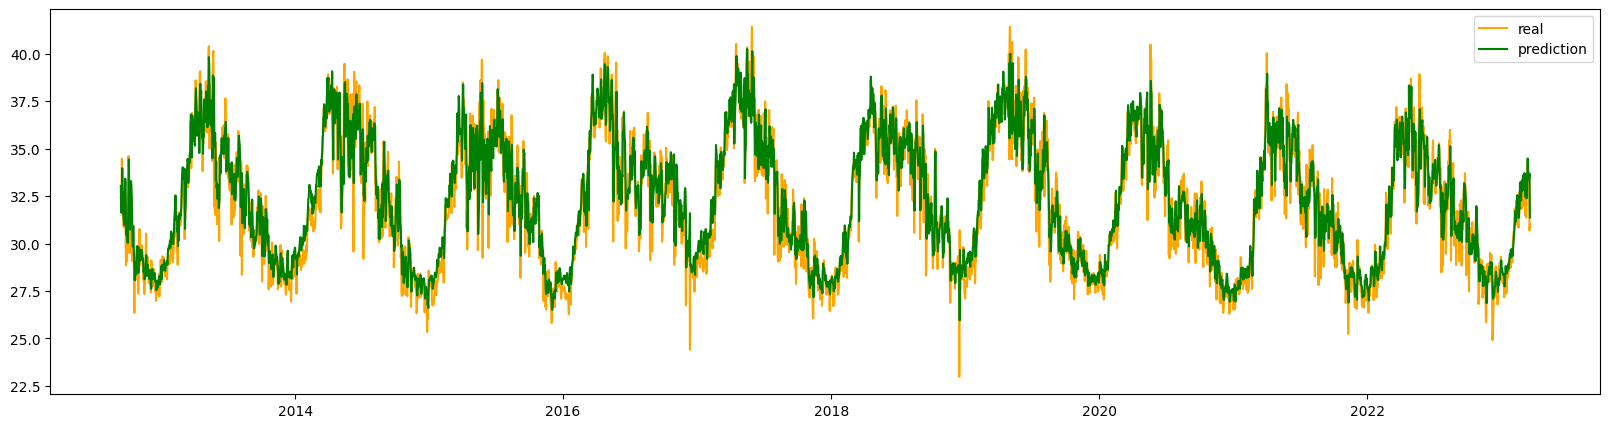

In [25]:
date = df.tail(3841).index
plt.figure(figsize=(20, 5))
plt.plot(date, Y_real[:,0], c = 'orange', label = 'real')
plt.plot(date, Temp, c = 'green', label = 'prediction')
plt.legend()

In [26]:
df.tail()

,tempMax,temp,tempMin,earthSkin,relativeHumidity,pressure,dew
dateTime,,,,,,,
2023-03-16,33.12,28.39,25.23,30.29,70.38,100.46,22.11
2023-03-17,33.15,28.41,25.22,30.23,70.88,100.47,22.23
2023-03-18,33.42,28.60,25.21,30.58,70.31,100.39,22.30
2023-03-19,30.69,27.34,25.32,28.55,77.56,100.26,22.90
2023-03-20,31.01,27.25,25.10,28.26,82.38,100.26,23.87
